In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import os
import sys

from matplotlib.patches import Patch
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

plt.rcParams['font.family'] = 'Times New Roman'

# Import pokie from pokie.py
from pokie import pokie, get_device

# Section 3.1: Linear Regression

In [3]:
# -------------------------------
# 0. CONFIGURATION
# -------------------------------
num_gt        = 5000               # Number of ground‑truth parameter draws
num_samples   = 1000               # Posterior samples per GT
n             = 100               # Observations per GT
true_sigma    = 1.0               # Observation noise σ
prior_mu      = np.zeros(2)       # Prior mean vector [m0, b0]
prior_Sigma   = np.eye(2) * 1.0   # Prior covariance (τ² I)
noise_levels  = [0.001, 0.01, 0.1, 0.15, 0.2, 0.25]
num_noise     = len(noise_levels)
curr_num_runs = 100

In [4]:
# -------------------------------
# 1. Storage
# -------------------------------
# ground_truths: shape (num_gt, 2) for [m*, b*]
m_stars       = np.random.normal(loc=0.0, scale=0.5, size=num_gt)  # e.g., mean=0, std=0.5
b_stars       = np.random.normal(loc=0.0, scale=2.0, size=num_gt)  # e.g., mean=0, std=2.0
ground_truths = np.stack([m_stars, b_stars], axis=1)  # shape (num_gt, 2)

# posteriors: shape (num_noise, num_gt, num_samples, 2)
posteriors = np.zeros((num_noise, num_gt, num_samples, 2))

In [5]:
# -------------------------------
# 2. Posterior Sampling Loop
# -------------------------------
for gt_idx in tqdm(range(num_gt), desc="Sampling Linear-Regression Posteriors"):
    m_star, b_star = ground_truths[gt_idx]
    # Generate data
    x = np.random.uniform(-1, 1, size=n)
    y = m_star * x + b_star \
        + np.random.normal(0, true_sigma, size=n)
    # Build design
    A = np.stack([x, np.ones(n)], axis=1)  # shape (n,2)
    
    # Precompute posterior natural parameters
    Sigma_n_inv = np.eye(n) / (true_sigma**2)
    Precision_post = np.linalg.inv(prior_Sigma) + A.T @ Sigma_n_inv @ A
    Sigma_post     = np.linalg.inv(Precision_post)
    mu_post        = Sigma_post @ (A.T @ Sigma_n_inv @ y + np.linalg.inv(prior_Sigma) @ prior_mu)
    
    # Draw posterior samples, with optional bias inflation
    for nl_idx, scale in enumerate(noise_levels):
        # simulate mis‑calibration by shifting the posterior mean
        delta = np.sqrt(scale) * np.array([1.0, 1.0])  # same shift for both m, b
        biased_mean = mu_post + delta
        # sample from N(biased_mean, Sigma_post)
        posteriors[nl_idx, gt_idx] = np.random.multivariate_normal(
            biased_mean, Sigma_post, size=num_samples
        )

Sampling Linear-Regression Posteriors: 100%|██████████| 5000/5000 [00:02<00:00, 2014.93it/s]


In [6]:
# -------------------------------
# 3. Normalization for Pokie
# -------------------------------
# We'll flatten all posterior samples + the GT vector, per-parameter, 
# then min/max rescale to [0,1] so Pokie operates on comparable scales.

gt_norm        = np.zeros_like(ground_truths)
posterior_norm = np.zeros_like(posteriors)

for gt_idx in range(num_gt):
    # stack all samples for both noise levels, plus the GT itself
    all_samps = np.vstack([
        posteriors[nl, gt_idx] for nl in range(num_noise)
    ] + [ground_truths[gt_idx:gt_idx+1]])
    
    mins = all_samps.min(axis=0)
    maxs = all_samps.max(axis=0)
    span = np.maximum(maxs - mins, 1e-8)
    
    # normalize
    gt_norm[gt_idx] = (ground_truths[gt_idx] - mins) / span
    for nl in range(num_noise):
        posterior_norm[nl, gt_idx] = (posteriors[nl, gt_idx] - mins) / span

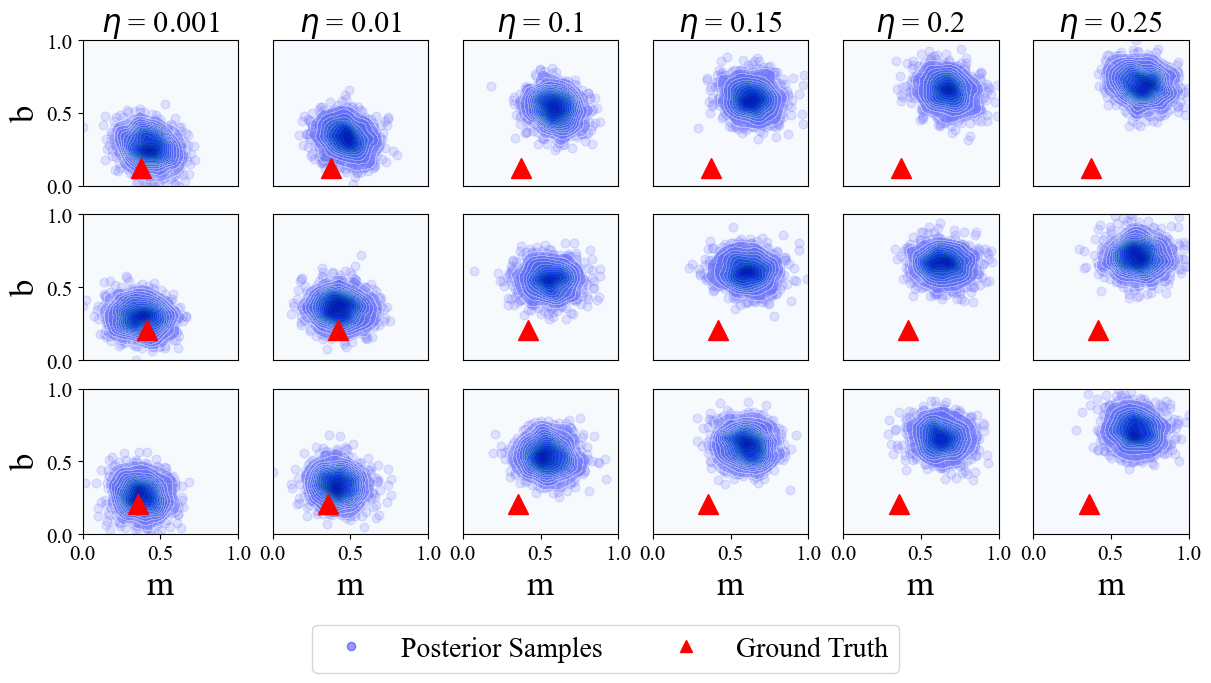

In [7]:


gt_indices = np.random.choice(num_gt, size=3, replace=False)
fig, axes = plt.subplots(len(gt_indices), num_noise, figsize=(12, 6), constrained_layout=True)

if len(gt_indices) == 1:
    axes = axes[np.newaxis, :]
if num_noise == 1:
    axes = axes[:, np.newaxis]

grid_size = 100
x_grid = np.linspace(0, 1, grid_size)
y_grid = np.linspace(0, 1, grid_size)

# Define tick values
xticks = [0.0, 0.5, 1.0]
yticks = [0.0, 0.5, 1.0]

X, Y = np.meshgrid(x_grid, y_grid)
grid_coords = np.vstack([X.ravel(), Y.ravel()])

for row_idx, gt_idx in enumerate(gt_indices):
    truth_sample = gt_norm[gt_idx]
    posterior_samples = posterior_norm[:, gt_idx]  # shape (num_noise, num_samples, 2)

    for col_idx in range(num_noise):
        ax = axes[row_idx, col_idx]
        samples = posterior_samples[col_idx]

        kde = gaussian_kde(samples.T)
        Z = kde(grid_coords).reshape(grid_size, grid_size)

        # Scatter and KDE
        ax.scatter(samples[:, 0], samples[:, 1], s=40, color='blue', alpha=0.2)
        ax.contourf(X, Y, Z, levels=15, cmap="Blues", alpha=0.5)

        # Ground truth
        ax.plot(truth_sample[0], truth_sample[1], 'r^', markersize=15)
        
        # Only apply to bottom row and left column
        if row_idx < len(gt_indices) - 1:
            ax.set_xticks([])
        else:
            ax.set_xticks(xticks)

        if col_idx > 0:
            ax.set_yticks([])
        else:
            ax.set_yticks(yticks)

        ax.tick_params(axis='both', labelsize=15)

        # Labels
        if row_idx == len(gt_indices) - 1:
            ax.set_xlabel("m", fontsize=25)
        if col_idx == 0:
            ax.set_ylabel("b", fontsize=25)

        # Titles
        if row_idx == 0:
            ax.set_title(rf"$\eta$ = {noise_levels[col_idx]}", fontsize=22)

# Add a single legend (optional: outside the figure or in a free subplot)
legend_elements = [
    Line2D([0], [0], marker='o', color='blue', linestyle='None', 
           markersize=6, alpha=0.4, label='Posterior Samples'),
    Line2D([0], [0], marker='^', color='red', linestyle='None', 
           markersize=8, label='Ground Truth')
]
fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.01),
           ncol=2, fontsize=20, frameon=True)

# Save
plt.savefig('./PDF_Plots/LR_posterior_cleaned.pdf', dpi=300, bbox_inches='tight')
plt.savefig('./PNG_Plots/LR_posterior_cleaned.png', dpi=300, bbox_inches='tight')
plt.show()